In [2]:
from datasets import load_dataset
import os
from transformers import CLIPTextModel, CLIPTokenizer
import torch

/home/t-ryanteehan/miniconda3/envs/diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
files = os.listdir("diffusiondb_data/export/home/ra63ral/dev/diffusion-distillation-datasets/data/diffusiondb/prompt_shards/")

files = ["diffusiondb_data/export/home/ra63ral/dev/diffusion-distillation-datasets/data/diffusiondb/prompt_shards/" + f for f in files]

In [4]:
all_prompts = []

for file in files:
    with open(file, 'r') as fp:
        lines = [l.strip() for l in fp.readlines()]
        all_prompts += lines

In [12]:
medical_prompts = []

for p in all_prompts:
    if "oxygen mask" in p:
        medical_prompts.append(p)

In [11]:
medical_prompts[0]

'ww2 photo of darth vader shaking hands with adolf hitler, highly detailed faces'

In [34]:
from sentence_transformers import SentenceTransformer


In [71]:
import numpy as np
import gc

In [72]:
# 2. Let Python’s GC break the last references
gc.collect()                         # host-side sweep  :contentReference[oaicite:0]{index=0}

# 3. Hand memory back to the CUDA driver
torch.cuda.empty_cache()             # flush the caching allocator  :contentReference[oaicite:1]{index=1}
torch.cuda.ipc_collect()             # drop any IPC handles          :contentReference[oaicite:2]{index=2}


In [73]:
model = SentenceTransformer('sentence-transformers/sentence-t5-base').to("cuda")

sample_idxs = np.random.choice(len(all_prompts), size=10000, replace=False)
sampled_prompts = [all_prompts[i] for i in sample_idxs]
embeds = model.encode(sampled_prompts, batch_size=100)


In [74]:
centered = embeds - embeds.mean(axis=0, keepdims=True)

In [75]:
from sklearn.decomposition import PCA

In [79]:
pca = PCA(n_components=1)
transformed_embeds = pca.fit_transform(centered)

In [83]:
transformed_embeds.shape

(10000, 1)

In [84]:
def extreme_indices(a, pct):
    """
    a   : numpy array, any shape
    pct : float, percentage in (0,100) – e.g. 5.0 for top/bottom 5 %
    returns (bottom_idx, top_idx) as 1-D index arrays that map into `a.ravel()`
    """
    x = a.ravel()                          # flatten, keeps original ordering
    n = x.size
    k = int(np.ceil(pct/100 * n))          # number of elements in each tail

    # bottom k (smallest) – argpartition puts the k smallest in the first k slots
    bot_idx = np.argpartition(x, k-1)[:k]

    # top k (largest) – negative index trick
    top_idx = np.argpartition(x, -k)[-k:]

    # optional: order them if you need sorted tails
    # bot_idx = bot_idx[np.argsort(x[bot_idx])]
    # top_idx = top_idx[np.argsort(-x[top_idx])]

    return bot_idx, top_idx


In [85]:
bottom, top = extreme_indices(transformed_embeds, 20)

In [86]:
pca = PCA(n_components=2)
transformed_embeds = pca.fit_transform(centered)

In [90]:
rows = np.r_[bottom, top]
selected = transformed_embeds[rows]
selected.shape

(4000, 2)

In [80]:
import matplotlib.pyplot as plt

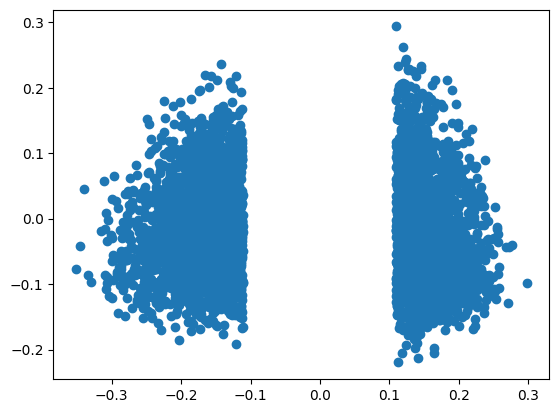

In [92]:
plt.scatter(selected[:,0], selected[:,1])